In [399]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from typing import List

import torch
from torch import nn, optim, utils
import numpy as np
import os
import time
import dill
import json
import random
import pathlib
import warnings
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from scipy.stats.distributions import chi2
from scipy.spatial import distance
from ithaca365.ithaca365 import Ithaca365
import os.path as osp

from ithaca365.utils.geometry_utils import view_points
from ithaca365.utils.data_classes import LidarPointCloud
import scipy
from pyquaternion import Quaternion
import time
from PIL import Image
import logging
from ithaca365.utils.data_io import load_velo_scan
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [385]:
nusc = Ithaca365(version='v1.2', dataroot='/share/campbell/Skynet/nuScene_format/v1.2', verbose=True)

Loading Ithaca365 tables for version v1.2...
6 category,
1 attribute,
4 visibility,
25839 instance,
3 sensor,
3 calibrated_sensor,
783830 ego_pose,
44 log,
44 scene,
29595 sample,
2351490 sample_data,
25839 sample_annotation,
1 map,
2579 location,
5 weather,
Done loading in 45.400 seconds.
Reverse indexing ...
Done reverse indexing in 7.7 seconds.


In [350]:
def moving_average(arr, n):
    """
    This function takes in a 1-dimensional NumPy array and averages every element with the next n elements.
    
    :param arr: a 1-dimensional NumPy array
    :param n: an integer, the number of elements to average with the current element
    :return: a new NumPy array with the moving average values
    
    """
    # Check if input array is valid
    if not isinstance(arr, np.ndarray) or len(arr.shape) != 1:
        raise ValueError("Input array must be a 1-dimensional NumPy array.")
    
    # Check if window size is valid
    if not isinstance(n, int) or n < 1 or n >= len(arr):
        raise ValueError("Window size must be a positive integer smaller than the length of the input array.")
    
    # Create a new array to hold the moving averages
    avg_arr = np.zeros(len(arr) - n + 1)
    
    # Compute the moving averages
    for i in range(len(avg_arr)):
        avg_arr[i] = np.mean(arr[i:i+n])
    
    return avg_arr

In [316]:
def single_mh(gt, mean_predictions, cov_predictions):
    m_dist = []
    for t in range(gt.shape[0]):
        m_dist.append(distance.mahalanobis(mean_predictions[t], gt[t], np.linalg.inv(cov_predictions[t])))
    return m_dist

def visualize_mh(mh, mean):
    PF = 0.95
    alpha = 1-PF
    anom = mh >= chi2.ppf(1-alpha, 2)
    plt.plot(mean[:,0], mean[:,1], c='black', zorder=-1)
    plt.scatter(mean[anom,0], mean[anom,1], c='b')
    plt.scatter(mean[~anom,0], mean[~anom,1], c='r')

In [324]:
# test = m_dist[t][node]>=chi2.ppf(1-alpha, 2)
def plot_n_gmm_trajectories(ground_truth: np.ndarray, gmm_means: np.ndarray, gmm_covariances: np.ndarray, gmm_weights: np.ndarray, num_components: int):
    SIG_LEVEL = 3
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot ground truth trajectory
    ax.plot(ground_truth[:, 0], ground_truth[:, 1], '-ok', label='Ground Truth')
    
#     for sample in range(gmm_means.shape[0]): # go through samples
    
    for sample in range(1): # go through samples
        sort_index = np.argsort(gmm_weights[sample,0])
        gmm_means = gmm_means[:,:,sort_index,:]
        gmm_covariances = gmm_covariances[:,:,sort_index,:,:]
        gmm_weights = gmm_weights[:,:,sort_index]
    # Plot predicted trajectories as GMM components
        for i in range(num_components): # go through compoents
            mean = gmm_means[sample,:,i,:]
            cov = gmm_covariances[sample,:,i,:,:]
            weight = gmm_weights[sample,:,i]
            mh = single_mh(ground_truth, mean, cov)
            visualize_mh(mh, mean)
            
            for t in range(mean.shape[0]):
                cov_t = cov[t]
                weight_t = weight[t]
                mean_t = mean[t]
                # Plot ellipse representing GMM component
                eigenvalues, eigenvectors = np.linalg.eigh(cov_t)
                angle = np.degrees(np.arctan2(*eigenvectors[1]))
                ellipse = Ellipse(xy=mean_t, width=SIG_LEVEL * np.sqrt(eigenvalues[0]), height=SIG_LEVEL * np.sqrt(eigenvalues[1]), angle=angle, alpha=weight_t, edgecolor='black', facecolor='gray')
                ax.add_artist(ellipse)
                

    # Set axis labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    plt.show()

In [325]:
def plot_highest_gmm(ground_truth: np.ndarray, gmm_means: np.ndarray, gmm_covariances: np.ndarray, gmm_weights: np.ndarray):
    SIG_LEVEL = 3
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot ground truth trajectory
    ax.plot(ground_truth[:, 0], ground_truth[:, 1], '-ok', label='Ground Truth')
    
    for sample in range(gmm_means.shape[0]): # go through samples

        i = np.argmax(gmm_weights[sample,0])
        mean = gmm_means[sample,:,i,:]
        cov = gmm_covariances[sample,:,i,:,:]
        weight = gmm_weights[sample,:,i]
#         ax.plot(mean[:, 0], mean[:, 1], '-or')
        mh = single_mh(ground_truth, mean, cov)
        visualize_mh(mh, mean)
        for t in range(mean.shape[0]):
            cov_t = cov[t]
            weight_t = weight[t]
            mean_t = mean[t]
            # Plot ellipse representing GMM component
            eigenvalues, eigenvectors = np.linalg.eigh(cov_t)
            angle = np.degrees(np.arctan2(*eigenvectors[1]))
            ellipse = Ellipse(xy=mean_t, width=SIG_LEVEL * np.sqrt(eigenvalues[0]), height=SIG_LEVEL * np.sqrt(eigenvalues[1]), angle=angle, alpha=weight_t, edgecolor='black', facecolor='gray')
            ax.add_artist(ellipse)
            

    # Set axis labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    plt.show()

In [357]:
def calc_mh(ground_truth, gmm_means, gmm_covariances, gmm_weights):
    for sample in range(1): # just use first sample
        i = np.argmax(gmm_weights[sample,0])
        mean = gmm_means[sample,:,i,:]
        cov = gmm_covariances[sample,:,i,:,:]
        weight = gmm_weights[sample,:,i]
#         ax.plot(mean[:, 0], mean[:, 1], '-or')
        mh = single_mh(ground_truth, mean, cov)
    return np.array(mh)

In [326]:
RESULTS_SAVE_PATH = '/home/jan268/temp/anomaly_data/'
folder_ = "models_12_Apr_2023_02_10_07prediction_ithaca365"
results_save_path = os.path.join(RESULTS_SAVE_PATH, folder_)
results_files = [f for f in listdir(results_save_path) if isfile(join(results_save_path, f))]

In [374]:
PF = 0.95
alpha = 1-PF
anom_thresh =  chi2.ppf(1-alpha, 2)


def get_multi_obs_thresh(N):
    upper =  chi2.ppf(1-alpha/2, 2*N)/N
    lower =  chi2.ppf(alpha/2, 2*N)/N
    return upper, lower

def plot_mh(mh, anom_thresh):
    mh_one = moving_average(mh, n=10)
    mh_two = moving_average(mh, n=20)
    mh_three = moving_average(mh, n=30)

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.plot(mh, 'k', label="1 future obs")
    plt.plot(np.ones(mh.shape)*anom_thresh, '--k')

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.plot(mh_one, 'b', label="10 future obs")
    upper, lower = get_multi_obs_thresh(10)
    plt.plot(np.ones(mh.shape)*upper, '--b')
    plt.plot(np.ones(mh.shape)*lower, '--b')

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.plot(mh_two, 'g', label="20 future obs")
    upper, lower = get_multi_obs_thresh(20)
    plt.plot(np.ones(mh.shape)*upper, '--g')
    plt.plot(np.ones(mh.shape)*lower, '--g')

    plt.legend()

In [407]:
# lidar_sd_token = 'ccedcc590b9548beafba8c19fbe444d4'
# cam_sd_token = 'f75ed782fd441b5acf401a94f49087c5'
# trajectories = toy_trajectories()
# gt = trajectories[0]
# predictions = trajectories[1:]
# # predictions.extend(anom_trajectories())
# fig = plotly_trajectory(lidar_sd_token, gt, predictions, nusc, dist_thresh=30, metric='range', cam_sd_token=None)
# fig.write_html(f"peak_lidar.html")

def plotly_trajectory(lidar_sd_token, gt, predictions, nusc, dist_thresh=40, metric='range', cam_sd_token=None):
    pointsensor = nusc.get('sample_data', lidar_sd_token)
    if metric == 'depth':
        assert cam_sd_token is not None
        cam = nusc.get('sample_data', cam_sd_token)
    data=[]
    
    if metric == 'depth':
        dist = get_depth(lidar_sd=pointsensor['token'], cam_sd=cam['token'])
        valid = np.absolute(depth) < dist_thresh
        data = get_lidar(data, lidar, valid, dist)
    elif metric == 'range':
        dist, lidar = get_range(lidar_sd=pointsensor['token'])
        valid = np.absolute(dist) < dist_thresh
        data = get_lidar(data, lidar, valid, dist)
    elif metric == 'p2':
        dist = get_point_persistency_score(lidar_sd_token, nusc, num_histories=20, ranges=(-70, 70), 
                                every_x_meter=5., max_neighbor_dist=0.3, num_workers=-1)
        valid = np.ones(dist.shape, dtype=bool)
        data = get_p2_lidar(data, lidar, dist, p2_thresh=.5)
    else:
        raise NotImplementedError
        
    #lidar
    
    #GT
    data.append(get_3dline(gt, color='red', colorscale='Viridis', anom_score=None))
    
    # prediction
    for sample in range(predictions.shape[0]): # go through samples

        i = np.argmax(gmm_weights[sample,0])
        mean = gmm_means[sample,:,i,:]
        cov = gmm_covariances[sample,:,i,:,:]
        weight = gmm_weights[sample,:,i]
        for i in range(num_components): # go through compoents
            mean = gmm_means[sample,:,i,:]
            # Array to be added as column
#             column_to_be_added = np.zeros(mean.shape[0]) 
#             mean_3d = np.append(mean, column_to_be_added, axis=1)
            data.append(get_3dline(mean, color='green', colorscale='Viridis', anom_score=None))
        
    fig = go.Figure(data=data, layout=ptc_layout_config)
    return fig

In [408]:
def get_current_sd(initial_sd, t, nusc):
    lidar_sd = nusc.get('sample_data', initial_sd)
    if t == 0:
        return lidar
    for i in range(t):
        lidar_sd = nusc.get('sample_data', lidar_sd['next'])
    return lidar_sd

def get_range(lidar_sd='ccedcc590b9548beafba8c19fbe444d4'):
    pointsensor = nusc.get('sample_data', lidar_sd)
    try:
        root = nusc.dataroot
    except AttributeError:
        root = nusc.data_path
        
    pcl_path = osp.join(root, pointsensor['filename'])
    pc = LidarPointCloud.from_file(pcl_path)
    lidar = pc.points
    return np.sqrt(lidar[0,:]**2+lidar[1,:]**2), lidar[0:3,:].T
def get_3dline(traj, color='red', colorscale='Viridis', anom_score=None, height=-0.8):
    z = np.ones(traj[:,0].shape)*height
    return go.Scatter3d(
    x=traj[:,0], y=traj[:,1], z=z,
    marker=dict(
        size=4,
        color=color,
#         colorscale=colorscale,
    ),
    line=dict(color=color,width=9))

def get_lidar(data, lidar, valid, dist):
    data.append(go.Scatter3d(
                x=lidar[valid,0],
                y=lidar[valid,1],
                z=lidar[valid,2],
                mode='markers',
                marker_size=1,
                marker_color=dist[valid],
                marker_colorscale='gray'))
    return data

ptc_layout_config={
    'title': {
        'text': '',
        'font': {
            'size': 20,
            'color': 'rgb(150,150,150)',
        },
        'xanchor': 'left',
        'yanchor': 'top'},
    'paper_bgcolor': 'rgb(255,255,255)',
    'width' : 800,
    'height' : 800,
    'margin' : {
        'l': 20,
        'r': 20,
        'b': 20,
        't': 20
    },
    'legend': {
        'font':{
            'size':20,
            'color': 'rgb(150,150,150)',
        },
        'itemsizing': 'constant'
    },
    "hoverlabel": {
        "namelength": -1,
    },
    'showlegend': False,
    'scene': {
          'aspectmode': 'manual',
          'aspectratio': {'x': 0.75, 'y': 0.75, 'z': 0.05},
          'camera': {'eye': {'x': 0, 'y': 0, 'z': 0.5}},
          'xaxis': {'color': 'rgb(150,150,150)',
                    'dtick': 10,
                    'gridcolor': 'rgb(100,100,100)',
                    'range': [-150, 150],
                    'showbackground': False,
                    'showgrid': False,
                    'showline': False,
                    'showticklabels': True,
                    'tickmode': 'linear',
                    'tickprefix': 'x:'},
          'yaxis': {'color': 'rgb(150,150,150)',
                    'dtick': 10,
                    'gridcolor': 'rgb(100,100,100)',
                    'range': [-150, 150],
                    'showbackground': False,
                    'showgrid': False,
                    'showline': False,
                    'showticklabels': False,
                    'tickmode': 'linear',
                    'tickprefix': 'y:'},
          'zaxis': {'color': 'rgb(150,150,150)',
                    'dtick': 10,
                    'gridcolor': 'rgb(100,100,100)',
                    'range': [-10, 10],
                    'showbackground': False,
                    'showgrid': False,
                    'showline': False,
                    'showticklabels': False,
                    'tickmode': 'linear',
                    'tickprefix': 'z:'}},
}


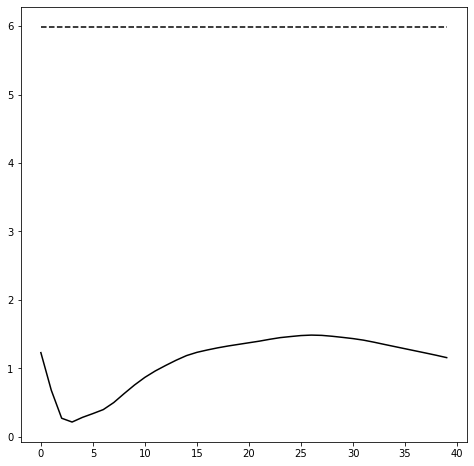

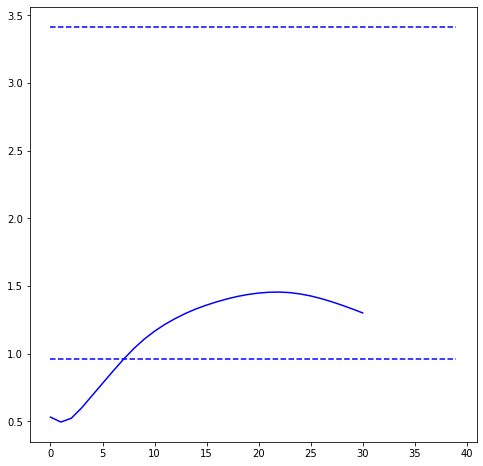

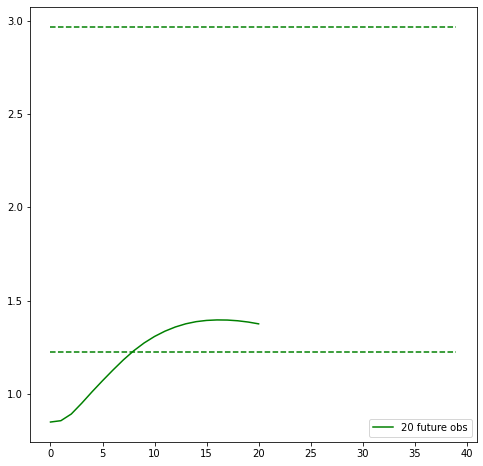

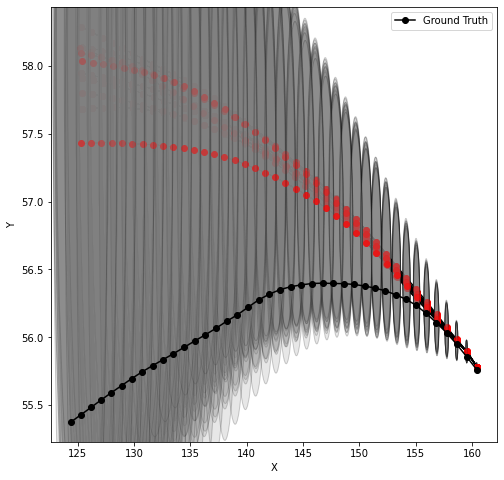

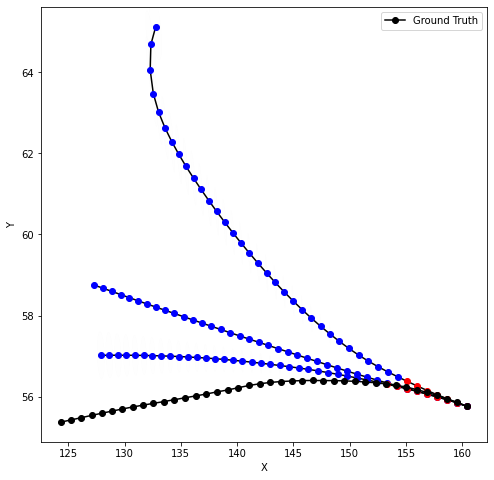

In [418]:
scene_data = {}
for result_file in results_files:
    file = os.path.join(results_save_path, result_file)
    with open(file, 'rb') as f:
        scene_dict = dill.load(f, encoding='latin1')
    
#     m_dist = scene_dict['m_dist']
    mean_prediction = scene_dict['mean_predictions']
    y_t = scene_dict['y_t']
    predictions = scene_dict['predictions']
    cov_predictions = scene_dict['cov_predictions']
    scene = scene_dict['scene']
    log_pis = scene_dict['log_pis']
    num_components = 3
    initial_sd_token = scene.name
    for t in range(1, scene.timesteps):
        scene_data.update({t: {}})
        nodes = scene.present_nodes(np.array([t]),min_history_timesteps=1,min_future_timesteps=0,return_robot=True)
        if nodes == {}:
            continue
            
        lidar_sd = get_current_sd(initial_sd_token, t, nusc)
        
        for node in nodes[t]:
#             print(node.is_robot)
            scene_data[t].update({node: {}})
            state = {'position': ['x', 'y']}
            ground_truth = node.get(tr_scene=np.array([t+1, t+40]), state=state)
            num_hist = node.history_points_at(t)
            gmm_means = np.array(mean_prediction[t][node])
            gmm_covariances = np.array(cov_predictions[t][node])
            gmm_weights = np.array(np.exp(log_pis[t][node]))
            
            mh = calc_mh(ground_truth, gmm_means, gmm_covariances, gmm_weights)
            
            plot_mh(mh, anom_thresh)
            scene_data[t][node].update({"num_hist": num_hist})
            scene_data[t][node].update({"mh": mh})
            scene_data[t][node].update({"mh": mh})
            
            
            
            plot_highest_gmm(ground_truth, gmm_means, gmm_covariances, gmm_weights)
            plot_n_gmm_trajectories(ground_truth, gmm_means, gmm_covariances, gmm_weights, num_components)
            fig = plotly_trajectory(lidar_sd['token'], ground_truth, gmm_means, nusc, dist_thresh=40, metric='range', cam_sd_token=None)
            fig.write_html(f"peak_lidar.html")

#         for node in y_t[t+1]:
            
#             np.exp(log_pis[t+1][node])
#             plot_gmm_trajectories(ground_truth: np.ndarray, gmm_means: np.ndarray, gmm_covariances: np.ndarray, gmm_weights: np.ndarray)
        break
    break

In [438]:
test = torch.tensor([[[0,0],[0,1], [0,2], [1, 3]]])
test

tensor([[[0, 0],
         [0, 1],
         [0, 2],
         [1, 3]]])

tensor([[[0, 0],
         [1, 0],
         [2, 0],
         [3, 1]]])